Hydrosat LST Hub URLs

* JupyterHub - https://fusion-stg.hydrosat.dev/hub
* API Tokens - https://fusion-stg-stac-server.hydrosat.dev/token
* STAC API - https://fusion-stg-stac-server.hydrosat.dev/stac

In [1]:
import json
import requests
import pystac
from pystac_client import Client
from pprint import pprint

from botocore.exceptions import ClientError
from shapely.geometry import box, mapping, Point, Polygon
from pyproj.crs import CRS
import geopandas as gpd

import xarray as xr
import rioxarray as rxr
import rasterio as rio

from matplotlib import pyplot as plt
import numpy as np

import os

In [2]:
with open('stac-token.txt') as f:
    accesstoken = f.readlines()[0].strip('\n')  

cat_url = 'https://fusion-stg-stac-server.hydrosat.dev/'
catalog = Client.open(cat_url, headers={'Authorization':'Bearer ' + accesstoken})
collections = catalog.get_children()
for collection in collections:
    print(f"{collection.id} - {collection.title}")

pydms_sharpened_ecostress - Sharpened LST using Sentinel-2 and ECOSTRESS
prepped_inputs_lc08 - Landsat-8 Surface Temperature
prepped_inputs_ecostress - ECOSTRESS Land Surface Temperature
prepped_inputs_s2 - Sentinel-2 Surface Reflectance
starfm_predictions_modis_ecostress - Predicted LST using MODIS and LC08
prepped_inputs_vnp43ma4 - VIIRS Surface Reflectance VNP43MA4
pydms_sharpened_modis - Sharpened LST using MODIS surface reflectance and LST
starfm_predictions_viirs_ecostress - Predicted LST using MODIS and LC08
prepped_inputs_mod21a1d - MODIS Land Surface Temperature MOD21
prepped_inputs_mcd43a4 - MODIS Surface Reflectance MCD43
prepped_inputs_vnp21a1d - VIIRS Land Surface Temperature VNP21
starfm_predictions_viirs_lc08 - Predicted LST using MODIS and LC08
starfm_predictions_modis_lc08 - Predicted LST using MODIS and LC08
pydms_sharpened_lc08 - Sharpened LST using Sentinel-2 and LC08
pydms_sharpened_viirs - Sharpened LST using VIIRS surface reflectance and LST


# try local class with FPK data

In [3]:
geom = {'type': 'Point', 'coordinates': [-105.1017, 48.30783]}

endpoint = 'https://fusion-stg-stac-server.hydrosat.dev'
catalog = Client.open(endpoint, headers={'Authorization':'Bearer ' + accesstoken})
search = catalog.search(
    collections = "pydms_sharpened_lc08",
    intersects = geom,
    datetime = ["2020-01-01T00:00:00Z","2021-12-31T23:59:50Z"],
    max_items = 500
)

# cat = Client.open(endpoint, headers={'Authorization':'Bearer ' + accesstoken})
# print(f"Serching {endpoint}")
# search = cat.search(**search_kwargs)
# print(f"{search.matched()} items found.")
items = search.get_all_items()
len(items)

23

In [4]:
from FH_Hydrosat import FH_Hydrosat
res = FH_Hydrosat(items)
ds = res.stack()
ds

<xarray.DataArray (time: 23, band: 1, y: 5490, x: 5490)>
dask.array<xarray-<this-array>, shape=(23, 1, 5490, 5490), dtype=float32, chunksize=(23, 1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.098e+05
  * y            (y) float64 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
    spatial_ref  int32 0
  * time         (time) object 2020-09-27T17:47:34.379812+00:00 ... 2020-04-0...
Attributes:
    STATISTICS_MAXIMUM:        304.66268920898
    STATISTICS_MEAN:           297.16231712848
    STATISTICS_MINIMUM:        263.33929443359
    STATISTICS_STDDEV:         2.3558347349829
    STATISTICS_VALID_PERCENT:  45.84
    scale_factor:              1.0
    add_offset:                0.0

## don't try to plot the full scenes, it will blow up the RAM. Instead, a small area centered around the point used for the query

In [5]:
p_geom = Point(geom['coordinates'][0], geom['coordinates'][1])
point_df = gpd.GeoDataFrame({'geometry':[p_geom]}, crs=CRS.from_epsg(4326))

<AxesSubplot:>

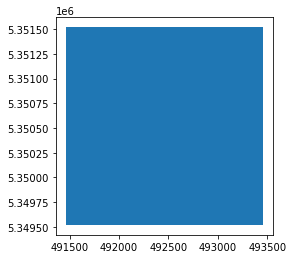

In [6]:
raster_crs = CRS.from_wkt(ds.spatial_ref.crs_wkt)
buffer_dist = 1000 # 1km in local UTM zone
poly_df = point_df.to_crs(raster_crs).buffer(buffer_dist, cap_style = 3) # square buffer
poly_df.plot()

In [7]:
# clip the raster dataset
ds_clip = ds.rio.clip(poly_df.geometry)
ds_clip

<xarray.DataArray (time: 23, band: 1, y: 100, x: 100)>
dask.array<copy, shape=(23, 1, 100, 100), dtype=float32, chunksize=(23, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.352e+06 5.351e+06 5.351e+06 ... 5.35e+06 5.35e+06
  * x            (x) float64 4.915e+05 4.915e+05 ... 4.934e+05 4.934e+05
  * band         (band) int32 1
  * time         (time) object 2020-09-27T17:47:34.379812+00:00 ... 2020-04-0...
    spatial_ref  int32 0
Attributes:
    STATISTICS_MAXIMUM:        304.66268920898
    STATISTICS_MEAN:           297.16231712848
    STATISTICS_MINIMUM:        263.33929443359
    STATISTICS_STDDEV:         2.3558347349829
    STATISTICS_VALID_PERCENT:  45.84
    scale_factor:              1.0
    add_offset:                0.0

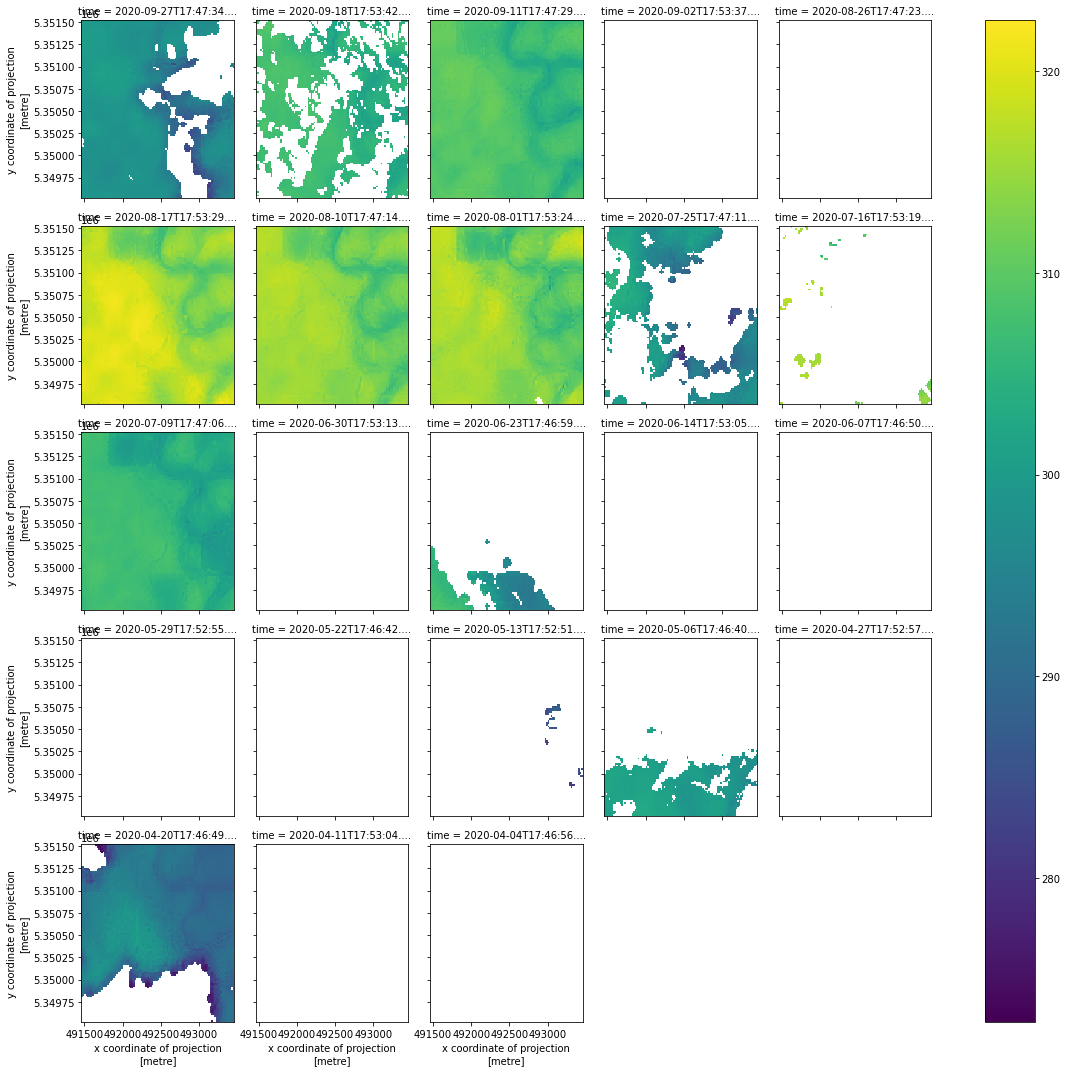

In [8]:
ds_clip.plot(x='x', y='y', col='time', col_wrap=5);

## plot a time series for the point location

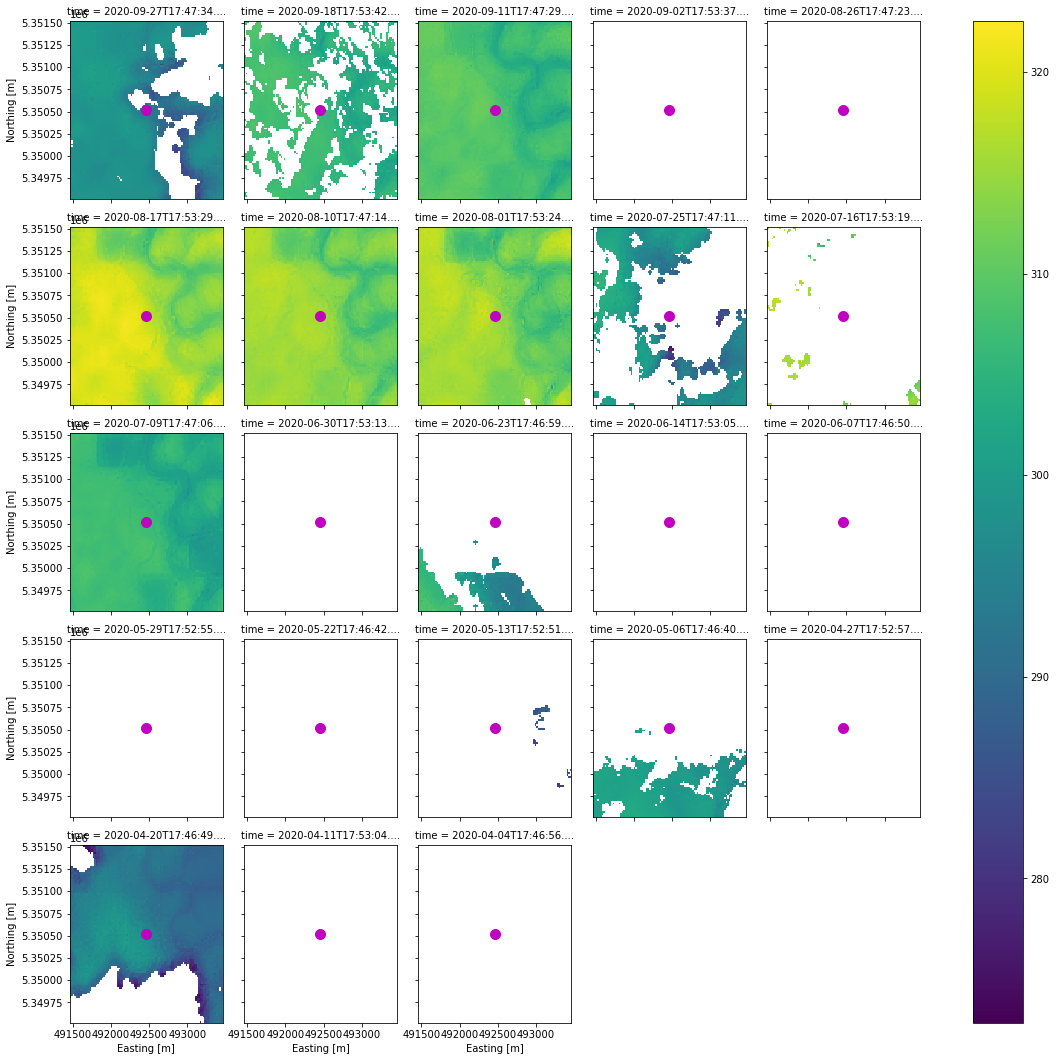

C:\software\Anaconda3\envs\hydrosat\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\software\Anaconda3\envs\hydrosat\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


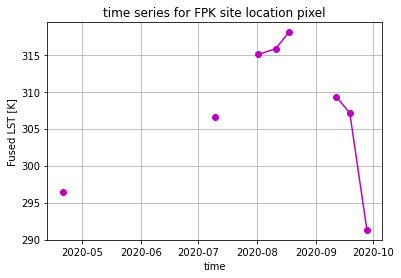

In [9]:
centroid = poly_df.geometry[0].centroid
set_x, set_y, pixtype = (centroid.x, centroid.y, 'FPK site location')

ax = ds_clip.plot(x='x', y='y', col='time', col_wrap=5)
ax.set_xlabels('Easting [m]')
ax.set_ylabels('Northing [m]')
ax.map(lambda: plt.plot(set_x, set_y, markersize=20, marker=".", color="m"))
plt.show()


ax = ds_clip.isel(band=0).sel(x=set_x, y=set_y, method='nearest', tolerance=20).plot(marker='o', c='m')
plt.title(f'time series for {pixtype} pixel')
plt.grid(True)
plt.ylabel('Fused LST [K]')
plt.show()

## reduce the area to the mean, and plot against the time series for the point location

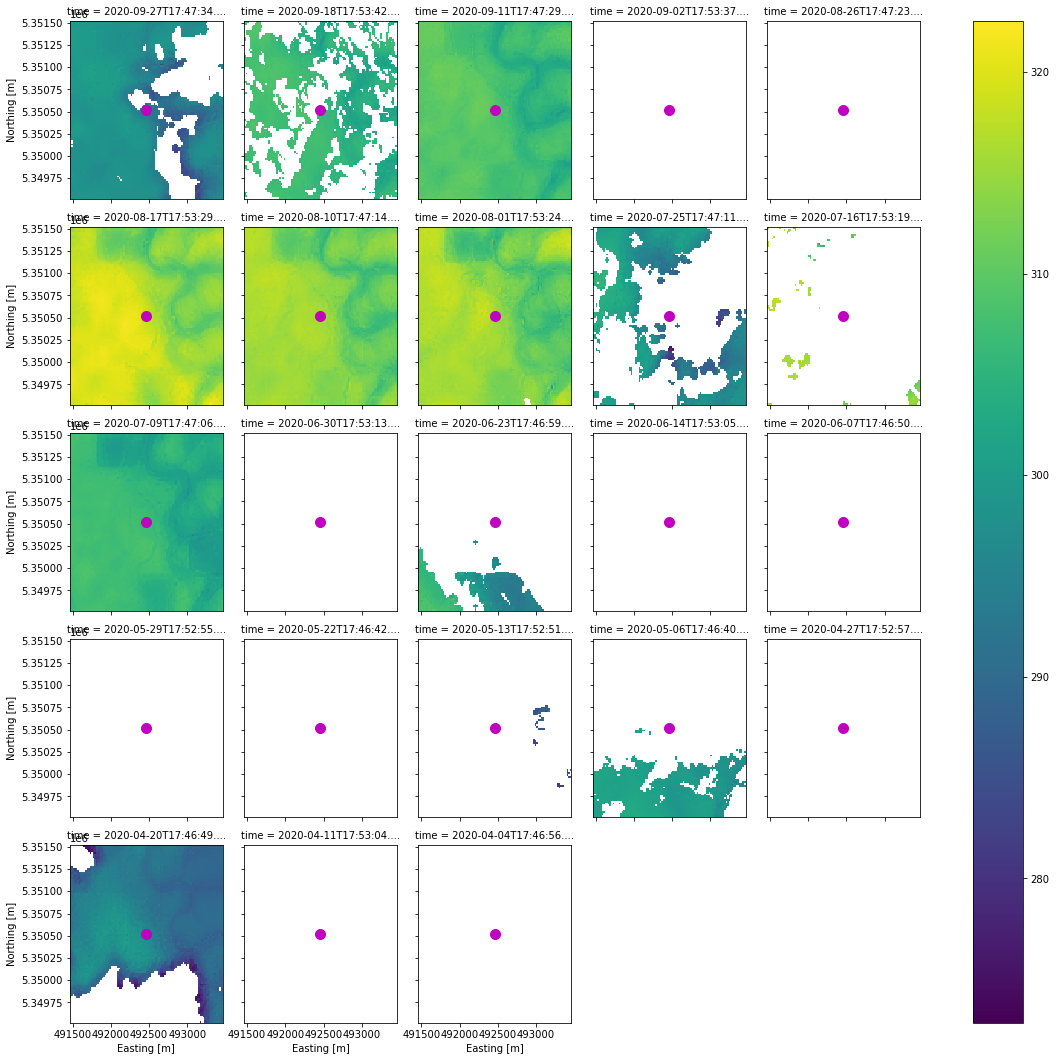

C:\software\Anaconda3\envs\hydrosat\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\software\Anaconda3\envs\hydrosat\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\software\Anaconda3\envs\hydrosat\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


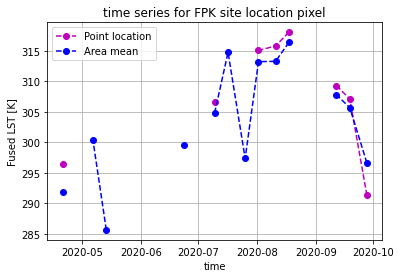

In [10]:
ax = ds_clip.plot(x='x', y='y', col='time', col_wrap=5)
ax.set_xlabels('Easting [m]')
ax.set_ylabels('Northing [m]')
ax.map(lambda: plt.plot(set_x, set_y, markersize=20, marker=".", color="m"))
plt.show()


ax = ds_clip.isel(band=0).sel(x=set_x, y=set_y, method='nearest', tolerance=20).plot(linestyle='--', marker='o', c='m', label='Point location')
ax = ds_clip.isel(band=0).mean(dim=('x', 'y')).plot(linestyle='--', marker='o', c='b', label='Area mean')
plt.title(f'time series for {pixtype} pixel')
plt.legend()
plt.grid(True)
plt.ylabel('Fused LST [K]')
plt.show()

## download a single file

In [11]:
# find which file has the most data in it
max_data_idx = np.argmax(ds_clip.count(dim=('x', 'y', 'band')).values)

outfile = f'./{os.path.basename(res.item_desc[max_data_idx])}'
print(outfile, os.path.exists(outfile))

res.download_single_asset(2)

print(outfile, os.path.exists(outfile))

./sharpened_13UDP_hires_lst_mosaic_screened_LC08_2020-09-11_with_S2B_13UDP_20200911_0_L2A_screened False
./sharpened_13UDP_hires_lst_mosaic_screened_LC08_2020-09-11_with_S2B_13UDP_20200911_0_L2A_screened True


## download multiple files, since there a few scenes that have full coverage for the AOI